In [1]:
import os
import pandas as pd
from PIL import Image
import numpy as np
from numpy import asarray
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms as T
from torchvision.transforms import Resize, ToTensor, Normalize
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torchvision.models as models
from torchsummary import summary

from tqdm import tqdm

# GPU 사용양 확인할 수 있는 util
from GPUtil import showUtilization as gpu_usage
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 | 98% | 56% |


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name(device))

Tesla V100-PCIE-32GB


In [4]:
label_path = '/opt/ml/split_labels/gender/'
train = pd.read_csv(label_path + 'train.csv')
valid = pd.read_csv(label_path + 'valid.csv')
x_train, y_train = train['path'], train['gender']
x_valid, y_valid = valid['path'], valid['gender']

In [5]:
test_path = '/opt/ml/input/data/eval/images/'

test = pd.read_csv('/opt/ml/input/data/eval/info.csv')
test_path = [os.path.join(test_path, img) for img in test.ImageID]

In [6]:
class TrainDataset(Dataset):
    
    def __init__(self, file_path, labels, transform, train=True):
        self.train = train
        self.transform = transform
        self.y = asarray(labels)
        self.X_path = asarray(file_path)
        self.X = []
        for x in tqdm(self.X_path):
            image = Image.open(x)
            image = asarray(image)
            self.X.append(image)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        aug = self.transform(image=X)
        X = aug['image']
        if self.train == False:
            return X
        return X, torch.tensor(y)

In [7]:
class TestDataset(Dataset):
    
    def __init__(self, file_path, transform):
        self.transform = transform
        self.X_path = asarray(file_path)
        self.X = []
        for x in tqdm(self.X_path):
            image = Image.open(x)
            image = asarray(image)
            self.X.append(image)
            
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = self.X[idx]
        aug = self.transform(image=X)
        X = aug['image']
        return X

In [8]:
CROP_SIZE = 330
RESIZE = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_aug = A.Compose([
    A.OpticalDistortion(p=0.5),
    A.OneOf([
        A.Cutout(p=1, num_holes=10, max_h_size=10, max_w_size=6),
        A.GridDistortion(p=1, num_steps=5, interpolation=1, border_mode=1, value=(0, 0, 0)),
    ], p=0.5),
    A.CenterCrop(height=CROP_SIZE+80, width=CROP_SIZE),
    A.Resize(height=RESIZE, width=RESIZE),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

test_aug = A.Compose([
    A.CenterCrop(height=CROP_SIZE+80, width=CROP_SIZE),
    A.Resize(height=RESIZE, width=RESIZE),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

/opt/conda/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [10]:
gender_train_dataset = TrainDataset(
    file_path = x_train,
    labels = y_train,
    transform = train_aug
)

100%|██████████| 17010/17010 [01:01<00:00, 277.23it/s]


In [11]:
gender_valid_dataset = TrainDataset(
    file_path = x_valid,
    labels = y_valid,
    transform = test_aug
)

100%|██████████| 1890/1890 [00:06<00:00, 284.08it/s]


In [12]:
test_dataset = TestDataset(
    file_path = test_path,
    transform = test_aug
)

100%|██████████| 12600/12600 [00:44<00:00, 285.08it/s]


In [13]:
gpu_usage()

| ID | GPU  | MEM |
-------------------
|  0 | 100% | 56% |


In [14]:
BATCH_SIZE = 128
gender_train_loader = DataLoader(gender_train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
gender_valid_loader = DataLoader(gender_valid_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [15]:
next(iter(gender_train_loader))[0].size()

torch.Size([128, 3, 224, 224])

In [43]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.base = models.resnet34(pretrained=True)
        self.base.fc = nn.Linear(512, 128, bias=True)
        self.final = nn.Linear(128, 2, bias=True)
        
    def forward(self, x):
        x = self.base(x)
        x = self.final(x)
        return x

In [44]:
GenderModel = Model().to(device)

In [47]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('gender_final_exp')

In [48]:
def train(model, optimizer, train_loader, val_loader, device, scheduler, writer, epochs=20):

    criterion = torch.nn.CrossEntropyLoss()
    loss_log = []
    for e in range(1, epochs+1):
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in tqdm(iter(train_loader)):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()        
            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch.squeeze())
            acc = class_acc(y_pred, y_batch.squeeze())

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
        scheduler.step()
        
        # validation set eval
        with torch.no_grad(): 
            val_loss = 0
            val_acc = 0
            for x_val, y_val in iter(val_loader):  
                x_val = x_val.to(device)  
                y_val = y_val.to(device)
#                 model.eval()  

                yhat = model(x_val)  
                val_loss += criterion(yhat, y_val.squeeze()).item()
                val_acc += class_acc(yhat, y_val.squeeze()).item()
        
        writer.add_scalars('Train/Valid Loss', {'train':epoch_loss/len(train_loader), 'valid':val_loss/len(val_loader)}, e)
        writer.add_scalars('Train/Valid Acc', {'train':epoch_acc/len(train_loader), 'valid':val_acc/len(val_loader)}, e)
        print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.4f} | Acc: {epoch_acc/len(train_loader):.3f} \
        | Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {val_acc/len(val_loader):.3f}')
        new_loss = val_loss/len(val_loader)
        loss_log.append(new_loss)
        if len(loss_log) <= 8:
            continue
        if np.mean(loss_log[-4:])/new_loss < 1:
            print('Early Stopping!')
            break

In [49]:
def class_acc(y_pred, y_test):    
    output = torch.argmax(y_pred, dim=1)
    correct = sum(output == y_test)/len(output)
    return correct

In [54]:
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR

LEARNING_RATE = 1e-6
criterion = nn.CrossEntropyLoss()
optG = Adam(GenderModel.parameters(), lr=LEARNING_RATE)
schG = StepLR(optG, step_size=4, gamma=0.5)
# optG = SGD(GenderModel.parameters(), lr=LEARNING_RATE, momentum=0.9)

In [55]:
train(
    model = GenderModel,
    optimizer = optG,
    train_loader = gender_train_loader,
    val_loader = gender_valid_loader,
    device = device,
    scheduler = schG,
    writer = writer,
    epochs = 3
)

  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 001: | Loss: 0.0002 | Acc: 1.000         | Val Loss: 0.0772 | Val Acc: 0.985


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 002: | Loss: 0.0000 | Acc: 1.000         | Val Loss: 0.0595 | Val Acc: 0.989


100%|██████████| 132/132 [01:37<00:00,  1.35it/s]


Epoch 003: | Loss: 0.0000 | Acc: 1.000         | Val Loss: 0.0821 | Val Acc: 0.986


In [56]:
def predictTestData(model, loader, transform, device):
#         model.eval()
        predict = []
        for images in tqdm(loader):
            with torch.no_grad():
                images = images.to(device)
                pred = model(images)
                pred = pred.argmax(dim=-1)
                predict.extend(pred.cpu().numpy())
#         self.data['ans'] = all_predictions
        return np.array(predict)

In [57]:
submission = pd.read_csv('/opt/ml/input/data/eval/info.csv')
submission.head()

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,0
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,0
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,0
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,0
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,0


In [58]:
submission['gender'] = predictTestData(GenderModel, test_loader, test_aug, device)

100%|██████████| 99/99 [00:36<00:00,  2.69it/s]


In [59]:
submission['gender'].value_counts().sort_index()

0    6842
1    5758
Name: gender, dtype: int64

In [60]:
test_transform = T.Compose([
    T.CenterCrop((CROP_SIZE+80, CROP_SIZE)),
    T.Resize((RESIZE, RESIZE)),
])

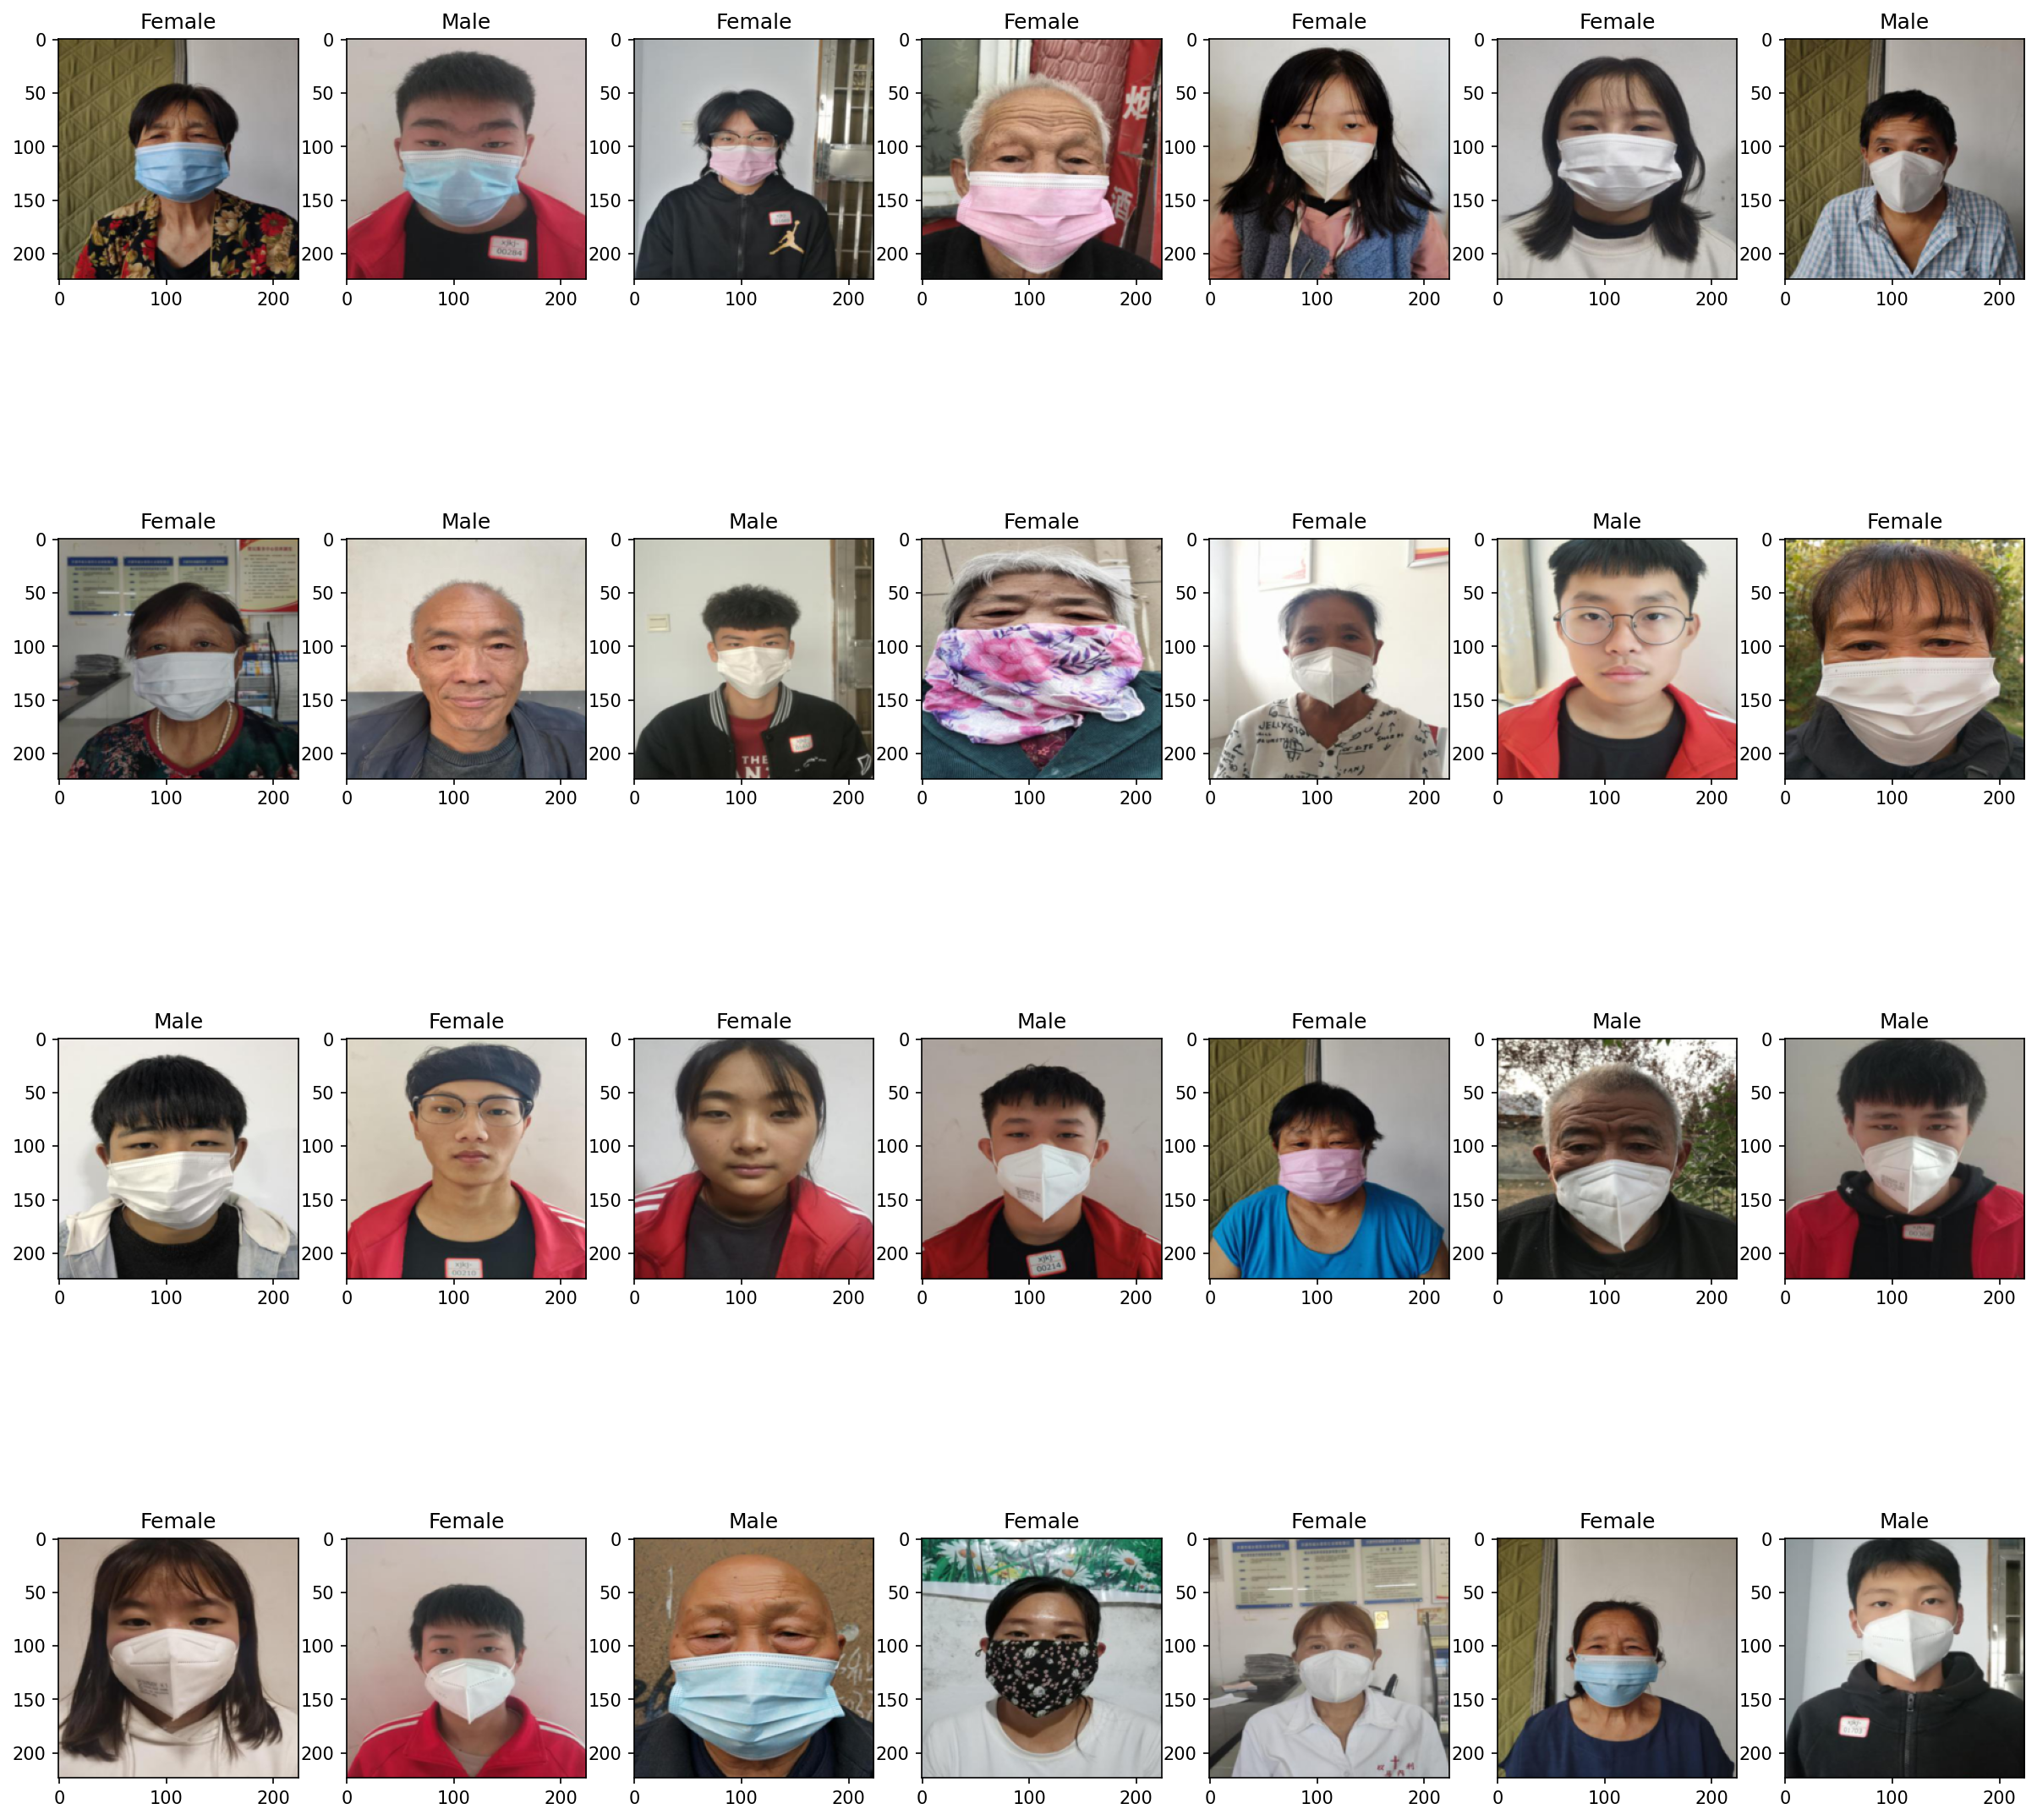

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
test_dir = '/opt/ml/input/data/eval/images/'

%matplotlib inline

gender = {0:'Male', 1:'Female'}

fig, axes = plt.subplots(4, 7, figsize=(20,20), dpi=150)
for i in range(4):
    for j in range(7):
        n = randint(0, 12599)
        im = Image.open(os.path.join(test_dir, submission.ImageID[n]))
        im = test_transform(im)
        axes[i][j].imshow(im)
        axes[i][j].set_title(gender[submission['gender'][n]])
plt.show()

In [73]:
init_dir = '/opt/ml/'
submission.to_csv(os.path.join(init_dir, 'gender.csv'))